In [1]:
import numpy as np
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import webbrowser
import os

In [2]:
# ============================================================================
# Parameters - Adjust these values as needed
# ============================================================================
S = 34.03          # Spot price
K = 40.00          # Strike price
r = 0.0412         # Risk-free rate
T = 30/365         # Time to expiry (years) - adjustable
sigma = 0.35       # Volatility (annualized)

In [3]:
# ============================================================================
# Helper Functions: Normal Distribution
# ============================================================================
def N(x):
    """Standard normal CDF using error function"""
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def n(x):
    """Standard normal PDF"""
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x * x)

# Vectorized versions for surface plots
erf_vec = np.vectorize(math.erf)
exp_vec = np.vectorize(math.exp)

def N_vec(x):
    """Vectorized standard normal CDF for NumPy arrays"""
    return 0.5 * (1.0 + erf_vec(x / np.sqrt(2.0)))

def n_vec(x):
    """Vectorized standard normal PDF for NumPy arrays"""
    return (1 / np.sqrt(2 * np.pi)) * exp_vec(-0.5 * x * x)

In [4]:
# ============================================================================
# Black-Scholes Pricing Function
# ============================================================================
def blackscholes(r, S, K, T, sigma, option_type="C"):
    """
    Calculate Black-Scholes option price
    
    Parameters:
    -----------
    r : float
        Risk-free rate
    S : float or array
        Spot price
    K : float
        Strike price
    T : float or array
        Time to expiry (years)
    sigma : float or array
        Volatility (annualized)
    option_type : str
        "C" for call, "P" for put
    
    Returns:
    --------
    float or array
        Option price
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type.upper() == "C":
        price = S*N_vec(d1) - K*np.exp(-r*T)*N_vec(d2)
    elif option_type.upper() == "P":
        price = K*np.exp(-r*T)*N_vec(-d2) - S*N_vec(-d1)
    else:
        raise ValueError("option_type must be 'C' or 'P'")
    
    return price

In [5]:
# ============================================================================
# Greeks Calculation Function
# ============================================================================
def bs_greeks(r, S, K, T, sigma, option_type="C"):
    """
    Calculate Black-Scholes Greeks
    
    Parameters:
    -----------
    r : float
        Risk-free rate
    S : float
        Spot price
    K : float
        Strike price
    T : float
        Time to expiry (years)
    sigma : float
        Volatility (annualized)
    option_type : str
        "C" for call, "P" for put
    
    Returns:
    --------
    dict
        Dictionary containing d1, d2, delta, gamma, vega, theta, rho
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type.upper() == "C":
        delta = N(d1)
        theta = -(S*n(d1)*sigma)/(2*math.sqrt(T)) - r*K*math.exp(-r*T)*N(d2)
        rho = K*T*math.exp(-r*T)*N(d2)
    elif option_type.upper() == "P":
        delta = N(d1) - 1
        theta = -(S*n(d1)*sigma)/(2*math.sqrt(T)) + r*K*math.exp(-r*T)*N(-d2)
        rho = -K*T*math.exp(-r*T)*N(-d2)
    else:
        raise ValueError("option_type must be 'C' or 'P'")
    
    gamma = n(d1) / (S*sigma*math.sqrt(T))
    vega = S*n(d1)*math.sqrt(T)
    
    return {
        "d1": d1,
        "d2": d2,
        "delta": delta,
        "gamma": gamma,
        "vega": vega,
        "theta": theta,
        "rho": rho
    }

In [6]:
# ============================================================================
# Calculate Option Prices and Greeks for Both Call and Put
# ============================================================================
call_price = blackscholes(r, S, K, T, sigma, "C")
put_price = blackscholes(r, S, K, T, sigma, "P")

call_greeks = bs_greeks(r, S, K, T, sigma, "C")
put_greeks = bs_greeks(r, S, K, T, sigma, "P")

print("="*70)
print(f"BLACK-SCHOLES OPTION PRICING")
print("="*70)
print(f"\nParameters:")
print(f"  Spot Price (S):        ${S:.2f}")
print(f"  Strike Price (K):      ${K:.2f}")
print(f"  Risk-free Rate (r):    {r*100:.2f}%")
print(f"  Time to Expiry (T):    {T:.4f} years ({T*365:.0f} days)")
print(f"  Volatility (σ):        {sigma*100:.2f}%")

print(f"\n{'='*70}")
print(f"CALL OPTION")
print(f"{'='*70}")
print(f"Call Option Price:     ${call_price:.4f}")
print(f"\nGreeks:")
print(f"  d1:                    {call_greeks['d1']:.4f}")
print(f"  d2:                    {call_greeks['d2']:.4f}")
print(f"  Delta (Δ):             {call_greeks['delta']:.4f}")
print(f"  Gamma (Γ):             {call_greeks['gamma']:.4f}")
print(f"  Vega (ν):              {call_greeks['vega']:.4f} (per 1% vol: {call_greeks['vega']/100:.4f})")
print(f"  Theta (Θ):             {call_greeks['theta']:.4f} per year ({call_greeks['theta']/365:.4f} per day)")
print(f"  Rho (ρ):               {call_greeks['rho']:.4f} (per 1% rate: {call_greeks['rho']/100:.4f})")

print(f"\n{'='*70}")
print(f"PUT OPTION")
print(f"{'='*70}")
print(f"Put Option Price:      ${put_price:.4f}")
print(f"\nGreeks:")
print(f"  d1:                    {put_greeks['d1']:.4f}")
print(f"  d2:                    {put_greeks['d2']:.4f}")
print(f"  Delta (Δ):             {put_greeks['delta']:.4f}")
print(f"  Gamma (Γ):             {put_greeks['gamma']:.4f}")
print(f"  Vega (ν):              {put_greeks['vega']:.4f} (per 1% vol: {put_greeks['vega']/100:.4f})")
print(f"  Theta (Θ):             {put_greeks['theta']:.4f} per year ({put_greeks['theta']/365:.4f} per day)")
print(f"  Rho (ρ):               {put_greeks['rho']:.4f} (per 1% rate: {put_greeks['rho']/100:.4f})")

print(f"\n{'='*70}")
print(f"PUT-CALL PARITY CHECK")
print(f"{'='*70}")
# Put-Call Parity: C - P = S - K*e^(-rT)
parity_lhs = call_price - put_price
parity_rhs = S - K*np.exp(-r*T)
parity_diff = abs(parity_lhs - parity_rhs)
print(f"  Call - Put:            ${parity_lhs:.4f}")
print(f"  S - K*e^(-rT):         ${parity_rhs:.4f}")
print(f"  Difference:            ${parity_diff:.6f}")
print(f"  Parity {'✓ SATISFIED' if parity_diff < 0.0001 else '✗ VIOLATED'}")
print("="*70)

BLACK-SCHOLES OPTION PRICING

Parameters:
  Spot Price (S):        $34.03
  Strike Price (K):      $40.00
  Risk-free Rate (r):    4.12%
  Time to Expiry (T):    0.0822 years (30 days)
  Volatility (σ):        35.00%

CALL OPTION
Call Option Price:     $0.0906

Greeks:
  d1:                    -1.5269
  d2:                    -1.6273
  Delta (Δ):             0.0634
  Gamma (Γ):             0.0364
  Vega (ν):              1.2131 (per 1% vol: 0.0121)
  Theta (Θ):             -2.6680 per year (-0.0073 per day)
  Rho (ρ):               0.1699 (per 1% rate: 0.0017)

PUT OPTION
Put Option Price:      $5.9253

Greeks:
  d1:                    -1.5269
  d2:                    -1.6273
  Delta (Δ):             -0.9366
  Gamma (Γ):             0.0364
  Vega (ν):              1.2131 (per 1% vol: 0.0121)
  Theta (Θ):             -1.0256 per year (-0.0028 per day)
  Rho (ρ):               -3.1067 (per 1% rate: -0.0311)

PUT-CALL PARITY CHECK
  Call - Put:            $-5.8348
  S - K*e^(-rT):        

In [7]:
# ============================================================================
# Surface A: Spot Price vs Volatility (with T fixed)
# ============================================================================
# Create meshgrid
S_range = np.linspace(S*0.5, S*1.5, 50)
sigma_range = np.linspace(0.1, 0.8, 50)
S_mesh, sigma_mesh = np.meshgrid(S_range, sigma_range)

# Calculate option prices
Z_call = blackscholes(r, S_mesh, K, T, sigma_mesh, "C")
Z_put = blackscholes(r, S_mesh, K, T, sigma_mesh, "P")

# Calculate Greeks for call
d1_mesh = (np.log(S_mesh/K) + (r + 0.5*sigma_mesh**2)*T) / (sigma_mesh*np.sqrt(T))
d2_mesh = d1_mesh - sigma_mesh*np.sqrt(T)

Z_delta_call = N_vec(d1_mesh)
Z_gamma = n_vec(d1_mesh) / (S_mesh*sigma_mesh*np.sqrt(T))
Z_vega = S_mesh*n_vec(d1_mesh)*np.sqrt(T)
Z_theta_call = -(S_mesh*n_vec(d1_mesh)*sigma_mesh)/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*N_vec(d2_mesh)
Z_rho_call = K*T*np.exp(-r*T)*N_vec(d2_mesh)

# Calculate Greeks for put
Z_delta_put = N_vec(d1_mesh) - 1
Z_theta_put = -(S_mesh*n_vec(d1_mesh)*sigma_mesh)/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*N_vec(-d2_mesh)
Z_rho_put = -K*T*np.exp(-r*T)*N_vec(-d2_mesh)

print(f"Surface A: Spot vs Volatility (T = {T:.4f} years fixed)")
print(f"  Spot range: ${S_range.min():.2f} to ${S_range.max():.2f}")
print(f"  Volatility range: {sigma_range.min()*100:.0f}% to {sigma_range.max()*100:.0f}%")

Surface A: Spot vs Volatility (T = 0.0822 years fixed)
  Spot range: $17.02 to $51.05
  Volatility range: 10% to 80%


In [8]:
# ============================================================================
# Surface B: Spot Price vs Time to Expiry (with σ fixed)
# ============================================================================
# Create meshgrid
S_range_b = np.linspace(S*0.5, S*1.5, 50)
T_range = np.linspace(1/365, 2, 50)  # From 1 day to 2 years
S_mesh_b, T_mesh = np.meshgrid(S_range_b, T_range)

# Calculate option prices
Z_call_b = blackscholes(r, S_mesh_b, K, T_mesh, sigma, "C")
Z_put_b = blackscholes(r, S_mesh_b, K, T_mesh, sigma, "P")

# Calculate Greeks for call
d1_mesh_b = (np.log(S_mesh_b/K) + (r + 0.5*sigma**2)*T_mesh) / (sigma*np.sqrt(T_mesh))
d2_mesh_b = d1_mesh_b - sigma*np.sqrt(T_mesh)

Z_delta_call_b = N_vec(d1_mesh_b)
Z_gamma_b = n_vec(d1_mesh_b) / (S_mesh_b*sigma*np.sqrt(T_mesh))
Z_vega_b = S_mesh_b*n_vec(d1_mesh_b)*np.sqrt(T_mesh)
Z_theta_call_b = -(S_mesh_b*n_vec(d1_mesh_b)*sigma)/(2*np.sqrt(T_mesh)) - r*K*np.exp(-r*T_mesh)*N_vec(d2_mesh_b)
Z_rho_call_b = K*T_mesh*np.exp(-r*T_mesh)*N_vec(d2_mesh_b)

# Calculate Greeks for put
Z_delta_put_b = N_vec(d1_mesh_b) - 1
Z_theta_put_b = -(S_mesh_b*n_vec(d1_mesh_b)*sigma)/(2*np.sqrt(T_mesh)) + r*K*np.exp(-r*T_mesh)*N_vec(-d2_mesh_b)
Z_rho_put_b = -K*T_mesh*np.exp(-r*T_mesh)*N_vec(-d2_mesh_b)

print(f"Surface B: Spot vs Time to Expiry (σ = {sigma*100:.0f}% fixed)")
print(f"  Spot range: ${S_range_b.min():.2f} to ${S_range_b.max():.2f}")
print(f"  Time range: {T_range.min()*365:.0f} days to {T_range.max():.2f} years")

Surface B: Spot vs Time to Expiry (σ = 35% fixed)
  Spot range: $17.02 to $51.05
  Time range: 1 days to 2.00 years


In [9]:
# ============================================================================
# Create Interactive 3D Plot with Dropdown Menu and Enhanced Axis Labels
# ============================================================================
fig = go.Figure()

# Surface A traces (Spot vs Volatility)
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_call, 
                         name='Call Price', colorscale='Viridis', visible=True))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_put, 
                         name='Put Price', colorscale='Plasma', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_delta_call, 
                         name='Delta (Call)', colorscale='RdBu', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_delta_put, 
                         name='Delta (Put)', colorscale='RdBu', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_gamma, 
                         name='Gamma', colorscale='YlOrRd', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_vega, 
                         name='Vega', colorscale='Greens', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_theta_call, 
                         name='Theta (Call)', colorscale='Blues', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_theta_put, 
                         name='Theta (Put)', colorscale='Blues', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_rho_call, 
                         name='Rho (Call)', colorscale='Purples', visible=False))
fig.add_trace(go.Surface(x=S_mesh, y=sigma_mesh*100, z=Z_rho_put, 
                         name='Rho (Put)', colorscale='Purples', visible=False))

# Surface B traces (Spot vs Time)
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_call_b, 
                         name='Call Price (T)', colorscale='Viridis', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_put_b, 
                         name='Put Price (T)', colorscale='Plasma', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_delta_call_b, 
                         name='Delta (Call, T)', colorscale='RdBu', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_delta_put_b, 
                         name='Delta (Put, T)', colorscale='RdBu', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_gamma_b, 
                         name='Gamma (T)', colorscale='YlOrRd', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_vega_b, 
                         name='Vega (T)', colorscale='Greens', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_theta_call_b, 
                         name='Theta (Call, T)', colorscale='Blues', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_theta_put_b, 
                         name='Theta (Put, T)', colorscale='Blues', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_rho_call_b, 
                         name='Rho (Call, T)', colorscale='Purples', visible=False))
fig.add_trace(go.Surface(x=S_mesh_b, y=T_mesh*365, z=Z_rho_put_b, 
                         name='Rho (Put, T)', colorscale='Purples', visible=False))

# Create dropdown menu
dropdown_buttons = [
    # Surface A (Spot vs Volatility)
    dict(label='Call Price (S vs σ)', method='update',
         args=[{'visible': [True] + [False]*18},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Call Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Price - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Put Price (S vs σ)', method='update',
         args=[{'visible': [False, True] + [False]*17},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Put Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Price - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Delta - Call (S vs σ)', method='update',
         args=[{'visible': [False]*2 + [True] + [False]*16},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Delta (Δ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Delta - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Delta - Put (S vs σ)', method='update',
         args=[{'visible': [False]*3 + [True] + [False]*15},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Delta (Δ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Delta - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Gamma (S vs σ)', method='update',
         args=[{'visible': [False]*4 + [True] + [False]*14},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Gamma (Γ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Gamma - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Vega (S vs σ)', method='update',
         args=[{'visible': [False]*5 + [True] + [False]*13},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Vega (ν)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Vega - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Theta - Call (S vs σ)', method='update',
         args=[{'visible': [False]*6 + [True] + [False]*12},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Theta (Θ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Theta - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Theta - Put (S vs σ)', method='update',
         args=[{'visible': [False]*7 + [True] + [False]*11},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Theta (Θ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Theta - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Rho - Call (S vs σ)', method='update',
         args=[{'visible': [False]*8 + [True] + [False]*10},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Rho (ρ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Rho - Spot vs Volatility (T={T*365:.0f} days)'}]),
    dict(label='Rho - Put (S vs σ)', method='update',
         args=[{'visible': [False]*9 + [True] + [False]*9},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Rho (ρ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Rho - Spot vs Volatility (T={T*365:.0f} days)'}]),
    
    # Surface B (Spot vs Time)
    dict(label='Call Price (S vs T)', method='update',
         args=[{'visible': [False]*10 + [True] + [False]*8},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Call Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Price - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Put Price (S vs T)', method='update',
         args=[{'visible': [False]*11 + [True] + [False]*7},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Put Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Price - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Delta - Call (S vs T)', method='update',
         args=[{'visible': [False]*12 + [True] + [False]*6},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Delta (Δ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Delta - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Delta - Put (S vs T)', method='update',
         args=[{'visible': [False]*13 + [True] + [False]*5},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Delta (Δ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Delta - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Gamma (S vs T)', method='update',
         args=[{'visible': [False]*14 + [True] + [False]*4},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Gamma (Γ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Gamma - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Vega (S vs T)', method='update',
         args=[{'visible': [False]*15 + [True] + [False]*3},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Vega (ν)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Vega - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Theta - Call (S vs T)', method='update',
         args=[{'visible': [False]*16 + [True] + [False]*2},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Theta (Θ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Theta - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Theta - Put (S vs T)', method='update',
         args=[{'visible': [False]*17 + [True] + [False]*1},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Theta (Θ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Theta - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Rho - Call (S vs T)', method='update',
         args=[{'visible': [False]*18 + [True] + [False]*1},
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Rho (ρ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Call Rho - Spot vs Time (σ={sigma*100:.0f}%)'}]),
    dict(label='Rho - Put (S vs T)', method='update',
         args=[{'visible': [False]*19 + [True]},  # ← FIXED! Shows trace 19 (the last one)
               {'scene.xaxis.title': dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.yaxis.title': dict(text='Time to Expiry (days)', font=dict(size=16, color='black', family='Arial Black')),
                'scene.zaxis.title': dict(text='Rho (ρ)', font=dict(size=16, color='black', family='Arial Black')),
                'title': f'Put Rho - Spot vs Time (σ={sigma*100:.0f}%)'}]),
]

fig.update_layout(
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.5,
            xanchor="center",
            y=1.0,
            yanchor="bottom",
            font=dict(size=12)
        ),
    ],
    title=dict(
        text=f'Call Price - Spot vs Volatility (T={T*365:.0f} days)',
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=18, color='black')
    ),
    scene=dict(
        xaxis=dict(
            title=dict(text='Spot Price ($)', font=dict(size=16, color='black', family='Arial Black')),
            backgroundcolor="rgb(230, 230,230)",
            gridcolor="white",
            showbackground=True,
            zerolinecolor="white"
        ),
        yaxis=dict(
            title=dict(text='Volatility (%)', font=dict(size=16, color='black', family='Arial Black')),
            backgroundcolor="rgb(230, 230,230)",
            gridcolor="white",
            showbackground=True,
            zerolinecolor="white"
        ),
        zaxis=dict(
            title=dict(text='Call Price ($)', font=dict(size=16, color='black', family='Arial Black')),
            backgroundcolor="rgb(230, 230,230)",
            gridcolor="white",
            showbackground=True,
            zerolinecolor="white"
        ),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=120)
)

print("Interactive 3D plot created successfully!")

Interactive 3D plot created successfully!



✓ Plot saved to: black_scholes_3d_surfaces.html
🌐 Opening plot in browser...
📊 Displaying plot inline in notebook


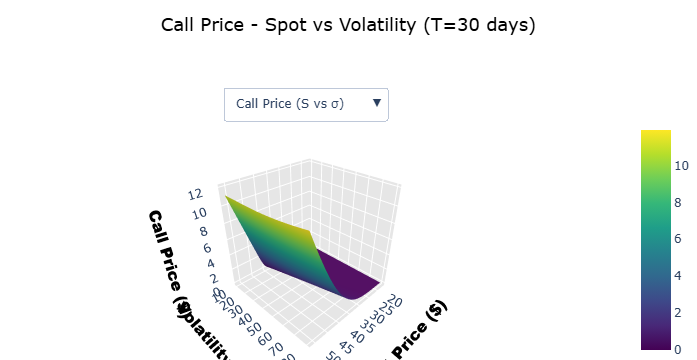

In [12]:
# ============================================================================
# Save and Display Plot (Works in Jupyter, Colab, and Binder)
# ============================================================================
output_file = "black_scholes_3d_surfaces.html"
fig.write_html(output_file)

print(f"\n✓ Plot saved to: {output_file}")

# Check if running in Colab or regular Jupyter
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # In Colab, display inline
    print("📊 Displaying plot inline (Colab environment detected)")
    fig.show()
else:
    # In local Jupyter, open in browser
    print("🌐 Opening plot in browser...")
    file_path = os.path.abspath(output_file)
    webbrowser.open('file://' + file_path)
    
    # Also display inline
    print("📊 Displaying plot inline in notebook")
    fig.show()